# Imports

In [35]:
# !pip install qiskit
# !pip install qiskit_aer
# !pip install qiskit_algorithms
# !pip install qiskit_ibm_runtime

In [36]:
# Usual imports
import numpy as np
import matplotlib.pyplot as plt

# Make text bigger
plt.rc('font', size=12.5)

# Linear Regression
from sklearn.linear_model import LinearRegression

# Qiskit (check versions)
import qiskit
import qiskit_aer
import qiskit_algorithms
import qiskit_ibm_runtime

print(f"Qiskit version {qiskit.__version__}")
print(f"Qiskit Aer version {qiskit_aer.__version__}")
print(f"Qiskit algorithms version {qiskit_algorithms.__version__}")
print(f"Qiskit IBM runtime version {qiskit_ibm_runtime.__version__}")


# Quantum Circuits!
from qiskit import QuantumCircuit, transpile

# General Imports
from qiskit.synthesis import EvolutionSynthesis, MatrixExponential, SuzukiTrotter
from qiskit.circuit.library import UnitaryGate, PauliEvolutionGate, Initialize
from qiskit.quantum_info import Statevector, Operator, SparsePauliOp, Pauli, DensityMatrix
from qiskit.visualization import plot_histogram, plot_bloch_multivector
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

# Noisy simulations
from qiskit_aer import AerSimulator
from qiskit_aer.noise import (
    NoiseModel,
    thermal_relaxation_error,
    amplitude_damping_error
)

# Running on a real quantum computer
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ibm_runtime import SamplerV2

# Run time-evolution problems
from qiskit_algorithms.time_evolvers import TrotterQRTE, TimeEvolutionProblem

Qiskit version 2.2.3
Qiskit Aer version 0.17.2
Qiskit algorithms version 0.4.0
Qiskit IBM runtime version 0.43.1


In [37]:
import warnings
from scipy.sparse import SparseEfficiencyWarning

warnings.filterwarnings("ignore", category=SparseEfficiencyWarning)

# Auxiliary Functions

## Bloch Sphere

In [38]:
def bloch_from_state(state: list) -> list:
    """
        Get the Bloch vector from the coefficients of a given state.
    """

    # Get phases
    phi0 = np.angle(state[0])
    phi1 = np.angle(state[1])

    # Get angles
    theta = 2 * np.arccos(np.abs(state[0]))
    phi = phi1 - phi0

    return [np.sin(theta)*np.cos(phi), np.sin(theta)*np.sin(phi), np.cos(theta)]

In [39]:
def plot_bloch(ss: list[Statevector], title: str, R: float = 0.99):
    """
        Plot the Bloch vectors of states in ss over time.
    """

    # Create a meshgrid with angular variables
    u, v = np.meshgrid(np.linspace(0, 2 * np.pi, 30), np.linspace(0, np.pi, 20))

    # Convert spherical coordinates to Cartesian
    x = R * np.cos(u) * np.sin(v)
    y = R * np.sin(u) * np.sin(v)
    z = R * np.cos(v)

    # Create 3D figure
    fig = plt.figure(figsize=(6, 5))
    ax = fig.add_subplot(111, projection='3d')

    # Plot wireframe
    ax.plot_surface(x, y, z, color='b', alpha=0.05)
    ax.plot_wireframe(x, y, z, color='b', alpha=0.05)

    # Check we are dealing with single qubit states
    N = ss[0].num_qubits
    if N != 1:
        raise ValueError("Invalid state")
    
    # Build array of 3D Bloch vectors
    vx, vy, vz = [], [], []
    for state in ss:
        bx, by, bz = bloch_from_state([state[0], state[1]])
        vx += [bx]
        vy += [by]
        vz += [bz]

    # Now we can visualize the evolution of the magnetic polarization by plotting the polar and azimuthal angles over time
    # Initial is blue and final is red
    ax.plot(vx, vy, vz, color='g')
    ax.quiver(0, 0, 0, vx[0], vy[0], vz[0], color='b')
    ax.quiver(0, 0, 0, vx[-1], vy[-1], vz[-1], color='r')

    # Labeling
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')

    # Show the plot
    plt.title(title)
    plt.show()

    return

## Running Simulations

In [40]:
def aersim(qc: QuantumCircuit, shots: int = 1024, noise: None | NoiseModel = None) -> dict[str, int]:
    # Create noisy simulator backend
    if noise:
        sim = AerSimulator(noise_model=noise)
    else:
        sim = AerSimulator()
    
    # Transpile circuit for noisy basis gates
    passmanager = generate_preset_pass_manager(
        optimization_level=3, backend=sim
    )
    qc = passmanager.run(qc)

    # Run
    job = sim.run(qc, shots=shots)
    result = job.result()
    counts = result.get_counts()

    return counts

## Hamiltonian Simulation

We want to simulate the following Hamiltonian:
\begin{align*}
    H = \sum_{j=0}^{n-1} 
    \underbrace{\left( 
    J_xX_j X_{j+1} + J_yY_j Y_{j+1} + J_zZ_j Z_{j+1} + z_j Z_j
    \right)}_{h_j},
\end{align*}

In [41]:
def hamiltonian(N: int, zz: np.ndarray, jj: list[float]) -> SparsePauliOp:
    """
        Build the Hamiltonian for our system with the specified parameters.
    """

    # Pauli Matrices
    X = SparsePauliOp("X")
    Y = SparsePauliOp("Y")
    Z = SparsePauliOp("Z")
    I = SparsePauliOp("I")

    # Coupled directions
    coupled = []
    if jj[0] != 0:
        coupled += [X]
    if jj[1] != 0:
        coupled += [Y]
    if jj[2] != 0:
        coupled += [Z]
    
    # Build Hamiltonian Term-by-Term
    tt = []

    # Apply XX, YY, and ZZ gates on index and index+1
    for index in range(N-1):
        for J, gate in zip(jj, coupled):
            term = gate ^ gate

            for _ in range(index):
                term = I ^ term
            
            for _ in range(index+2, N):
                term = term ^ I
            
            tt += [J * term]
    
    # Periodic Boundary Conditions (Commented for open boundary conditions)
    # for J, gate in zip(jj, coupled):
    #     term = gate.copy()
    #     for _ in range(N-2):
    #         term = term ^ gate
    #     term = term ^ gate

    #     tt += [J * term]

    # Apply field
    for index in range(N):
        term = Z.copy()

        for _ in range(index):
            term = I ^ term
        
        for _ in range(index+1, N):
            term = term ^ I
            
        tt += [zz[index] * term]
    
    # Build Hamiltonian
    ham = tt[0]
    for item in tt[1:]:
        ham += item

    return ham

In [42]:
def exact_sim(state: Statevector, N: int, zz: np.ndarray, jj: list[float], dt: float = 0.1, t: float = 2) -> tuple[list[float], list[Statevector]]:
    """
        Directly simulates the time-evolution using a matrix exponentiation.
    """

    # Build the Hamiltonian
    ham = hamiltonian(N, zz, jj)

    # Get the evolution opeartor
    evo = PauliEvolutionGate(ham, time=dt, label="U", synthesis=MatrixExponential())

    # Number of steps
    steps = int(t/dt)

    tt = [0.0]
    ss = [state]
    for index in range(steps):
        # Build the quantum circuit
        qc = QuantumCircuit(N)
        qc.initialize(state)
        qc.append(evo, range(N))

        # Get the final state
        state = Statevector(qc)

        # Save values
        tt += [dt * (index + 1)]
        ss += [state]

    return tt, ss

In [43]:
def suzuki_sim(state: Statevector, N: int, zz: np.ndarray, jj: list[float], order: int = 2, reps: int = 1, dt: float = 0.1, t: float = 2, circuit: bool = False) -> tuple[list[float], list[Statevector]] | QuantumCircuit:
    """
        Directly simulates the time-evolution using a single evolution operator.
    """

    # Build the Hamiltonian
    ham = hamiltonian(N, zz, jj)

    # Get the evolution operator
    evo = PauliEvolutionGate(ham, time=dt, label="U", synthesis=SuzukiTrotter(order, reps))

    # Number of steps
    steps = int(t/dt)

    tt = [0.0]
    ss = [state]
    for index in range(steps):
        # Build the quantum circuit
        qc = QuantumCircuit(N)
        qc.initialize(state)
        qc.append(evo, range(N))

        if circuit:
            return qc

        # Get the final state
        state = Statevector(qc)

        # Save values
        tt += [dt * (index + 1)]
        ss += [state]

    return tt, ss

In [44]:
def lieb_sim(state: Statevector, N: int, zz: np.ndarray, jj: list[float], ell: int, order: int = 2, reps: int = 1, dt: float = 0.1, t: float = 2, draw: bool = True) -> tuple[list[float], list[Statevector]]:
    """
        Simulates the time-evolution using Lieb-Robinson bounds.
    """

    # We are going to use m = 1
    # This means we have A = [0, N/2); B = [N/2, N)
    # And also Y = [N/2 - ell, N/2); Z = [N/2, N/2 + ell)
    # Therefore YZ = [N/2 - ell, N/2+ell)

    # Make sure N is even
    # if N % 2 == 1:
    #     raise ValueError("Parameter N must be even!")
    
    # Make sure N > ell + 2
    if N < ell:
        raise ValueError("We must have N > ell")
    

    # Qubits only on a single evolution operator
    left = (N - ell) // 2
    right = N - ell - left

    # Build the Hamiltonians
    hamA = hamiltonian(left + ell, zz[0:left+ell], jj)
    hamY = hamiltonian(ell, zz[left:left+ell], jj)
    hamYB = hamiltonian(right + ell, zz[left:N], jj)

    # Get the evolution opeartor
    evoA = PauliEvolutionGate(hamA, time=dt, label="$e^{-iH_A(dt)}$", synthesis=SuzukiTrotter(order, reps))
    evoY = PauliEvolutionGate(hamY, time=-dt, label="$e^{iH_Y(dt)}$", synthesis=SuzukiTrotter(order, reps))
    evoYB = PauliEvolutionGate(hamYB, time=dt, label="$e^{-iH_{B\\cup Y}(dt)}$", synthesis=SuzukiTrotter(order, reps))

    # Qubit indexes
    qq = range(N)

    # Number of steps
    steps = int(t/dt)

    tt = [0.0]
    ss = [state]
    for index in range(steps):
        # Build the quantum circuit
        qc = QuantumCircuit(N)
        
        # Initialize desired state
        ini = Initialize(state)
        ini.label = "$U_{\\psi}$"
        qc.append(ini, qq)

        # Append time-evolution
        qc.append(evoYB, qq[left:N])
        qc.append(evoY, qq[left:left+ell])
        qc.append(evoA, qq[0:left+ell])

        if draw and index == 0:
            display(qc.draw("mpl", style={"subfontsize": 0}))

        # Get the final state
        state = Statevector(qc)

        # Save values
        tt += [dt * (index + 1)]
        ss += [state]
    
    return tt, ss

In [45]:
def error_lieb(state: Statevector, N: int, zz: np.ndarray, jj: list[float], ell: int, order: int = 2, reps: int = 1, dt: float = 0.1, t: float = 2, exact: bool = True, draw: bool = True) -> tuple[np.ndarray, np.ndarray]:
    """
        Estimates the error of the Lieb simulator.
    """

    # Base simulation
    if exact:
        tt1, ss1 = exact_sim(state, N, zz, jj, dt, t)
    else:
        tt1, ss1 = suzuki_sim(state, N, zz, jj, order+2, reps, dt, t)

    # Lieb simulation
    tt2, ss2 = lieb_sim(state, N, zz, jj, ell, order, reps, dt, t, draw)
    
    # Overlap
    oo = [exact.inner(lieb) for exact, lieb in zip(ss1, ss2)]
    
    # Angle over time
    aa = [np.arccos(np.clip(np.abs(inner), 0, 1)) for inner in oo]

    return np.array(tt1), np.array(aa)

# Simulations

## One Qubit

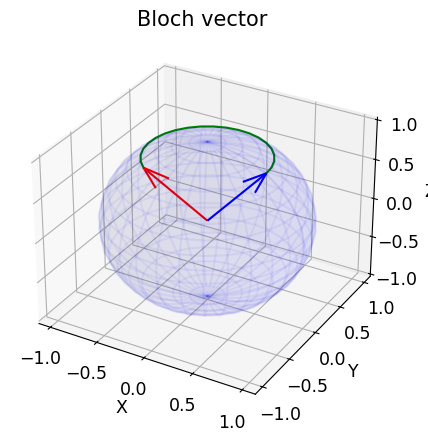

Initial state is blue and final is red.


In [46]:
# Simulation with one-qubit align to the field

# Parameters
state = Statevector([np.sqrt(0.90), np.sqrt(0.10)])
N = 1
zz = np.array([1])

# Run the simulation
tt, ss = suzuki_sim(state, N, zz, [0, 0, 0])

# View the results
plot_bloch(ss, "Bloch vector")
print("Initial state is blue and final is red.")

## Many Qubits

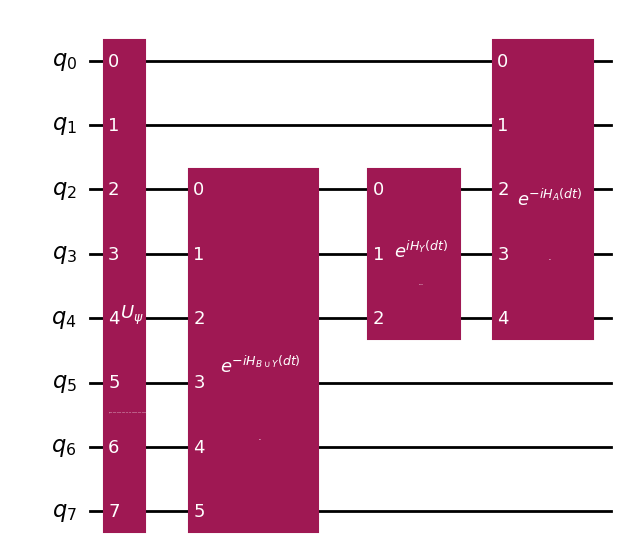

In [47]:
# PARAMETERS
N = 8
ell = 3

dt = 0.05
t = 1

# Coupling
jj = [0.25, 0.25, 0.25]

# Randomize field
zz = np.random.random(N) * 0.25

# Randomize initial state
state_type = np.random.random(N)
state_str = ["0" if num > 0.5 else "+" for num in state_type]
state = Statevector.from_label("".join(state_str))

# Compute error
tt, ee = error_lieb(state, N, zz, jj, ell, order=2, dt=dt, t=t, exact = True)

## Error as a function of $T$

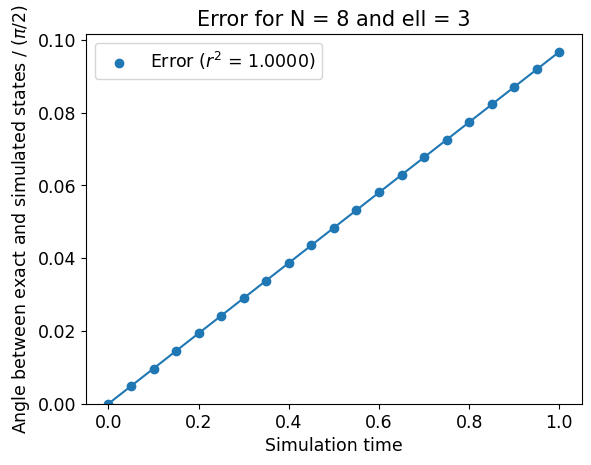

In [48]:
# PARAMETERS
N = 8
ell = 3

dt = 0.05
t = 1

# Coupling
jj = [0.25, 0.25, 0.25]

# Randomize field
zz = np.random.random(N) * 0.25

# Randomize initial state
state_type = np.random.random(N)
state_str = ["0" if num > 0.5 else "+" for num in state_type]
state = Statevector.from_label("".join(state_str))

# Compute error
tt, ee = error_lieb(state, N, zz, jj, ell, order=2, dt=dt, t=t, exact=True, draw=False)
tt_model = np.reshape(tt, (-1, 1))

# Linear regression
model = LinearRegression()
model.fit(tt_model, ee)

a = model.intercept_
b = model.coef_[0] 
r2 = model.score(tt_model, ee)

reg = b * tt + a

# Plot
plt.scatter(tt, ee/(np.pi/2), label=f"Error ($r^2$ = {r2:.4f})")
plt.plot(tt, reg/(np.pi/2))
plt.title(f"Error for N = {N} and ell = {ell}")
plt.xlabel("Simulation time")
plt.ylabel("Angle between exact and simulated states / $(\\pi/2)$")
plt.ylim(bottom=0)
plt.legend()
plt.show()

# Gate Counting

In [49]:
def qc_tgates(qc: QuantumCircuit) -> int:
    """
        Count the number of T gates in a circuit.
    """

    # Clifford + T
    basis = ["h", "s", "sdg", "t", "tdg", "cx"]

    # Decomposed circuit
    qc_decomp = transpile(qc, basis_gates=basis, optimization_level=2)

    # Count gates
    counts = qc_decomp.count_ops()
    
    return counts.get("t", 0)

In [50]:
def lieb_qc2(N: int, zz: np.ndarray, jj: list[float], ell: int, order: int = 2, reps: int = 1, dt: float = 0.1, draw: bool = False) -> QuantumCircuit:
    """
        Build the time-evolution operator using LR bounds, fully decomposing each block.
    """
    
    # Make sure N is divisible by 2*ell
    if N % (2*ell) != 0:
        raise ValueError("Parameter N must be a multiple of 2*ell!")
    
    # Build the quantum circuit
    qc = QuantumCircuit(N)

    # Qubit indexes
    qq = range(N)
    
    # Layer one Hamiltonians
    layer1 = N//(2*ell)
    big = 2 * ell
    for index in range(layer1):

        # Hamiltonian
        ham = hamiltonian(big, zz[big*index:big*(index+1)], jj)

        # Evolution Operator
        evo = PauliEvolutionGate(ham, dt, label=f"$e^{{-iH_{{A_{index}}}(dt)}}$", synthesis=SuzukiTrotter(order, reps))

        # Apply on the circuit
        qc.append(evo, qq[big*index:big*(index+1)])
    

    # Layer two Hamiltonians (each Hamiltonian has two smaller blocks, except the edge ones that have one)
    for index in range(2 * layer1 - 2):

        # Hamiltonian
        ham = hamiltonian(ell, zz[ell*(index+1):ell*(index+2)], jj)

        # Evolution Operator
        evo = PauliEvolutionGate(ham, -dt, label=f"$e^{{iH_{{Y_{index}}}(dt)}}$", synthesis=SuzukiTrotter(order, reps))

        # Apply on the circuit
        qc.append(evo, qq[ell*(index+1):ell*(index+2)])


    # Layer three Hamiltonians
    for index in range(layer1 - 1):

        # Hamiltonian
        ham = hamiltonian(big, zz[big*index + ell:big*(index+1) + ell], jj)

        # Evolution Operator
        evo = PauliEvolutionGate(ham, dt, label=f"$e^{{-iH_{{G_{index}}}(dt)}}$", synthesis=SuzukiTrotter(order, reps))

        # Apply on the circuit
        qc.append(evo, qq[big*index + ell:big*(index+1) + ell])

    if draw:
        display(qc.draw("mpl", style={"subfontsize": 0}))
    
    return qc

Computing N = 12 (max is N = 24)

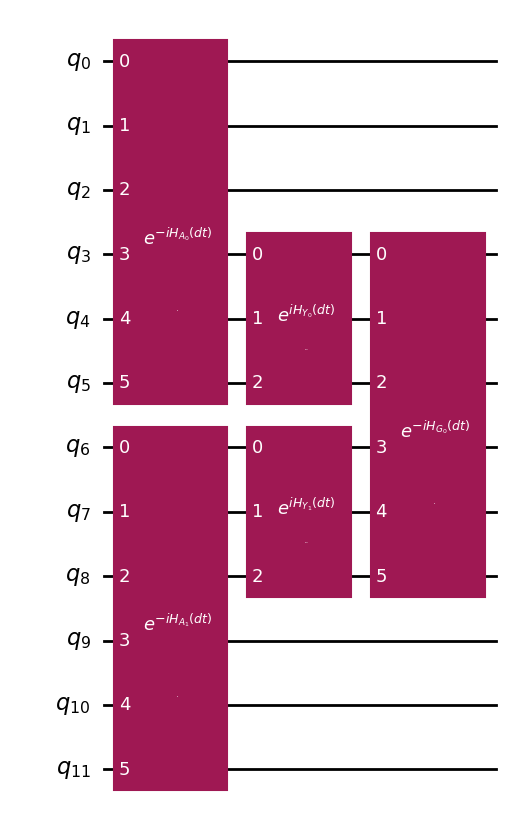

Computing N = 18 (max is N = 24)

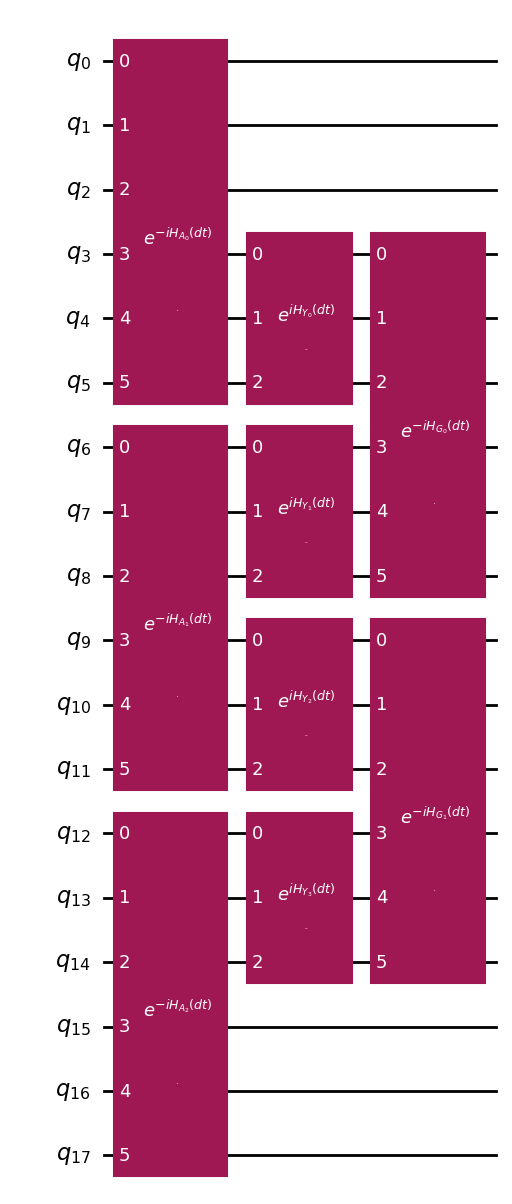

Computing N = 24 (max is N = 24)

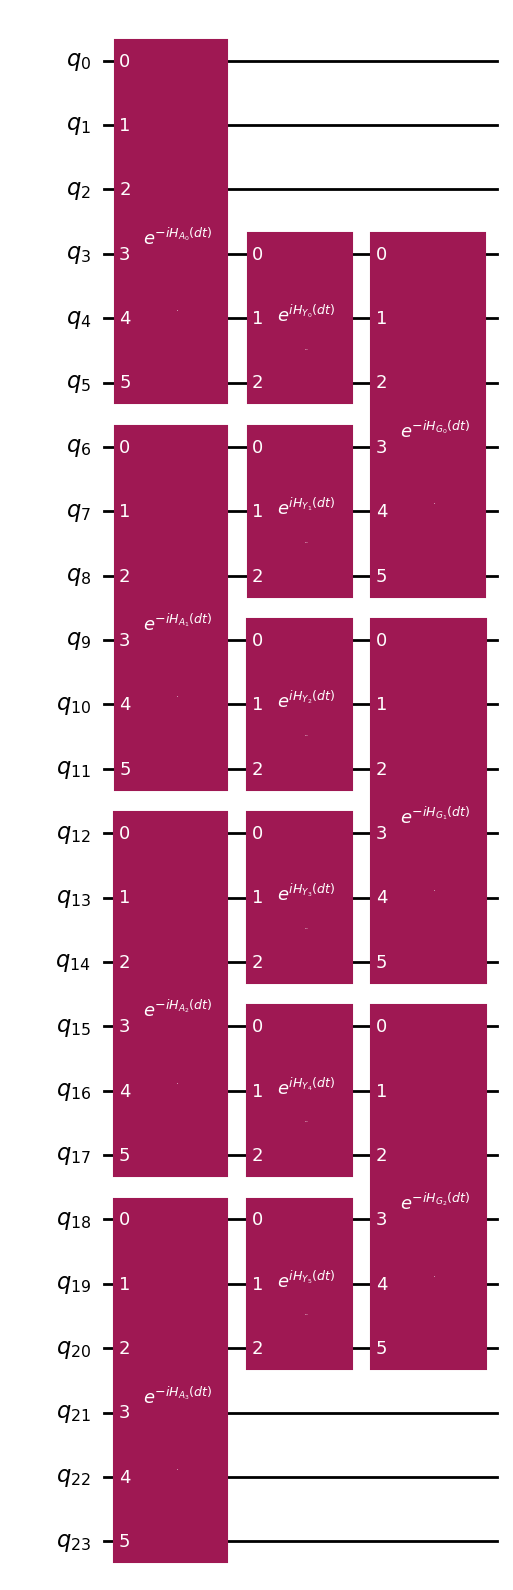

Equation Lieb: 78602.66666666664x + -301199.3333333328
Equation Suzuki: 31995.499999999993x + -22000.333333333256


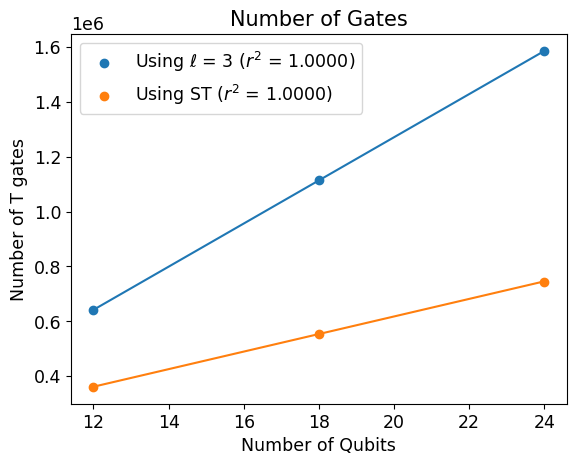

In [51]:
# PARAMETERS
ell = 3
Nstep = 3

dt = 0.1

order = 2
reps = 1

# Coupling
jj = [0.25, 0.25, 0.25]

# Run simulation for each N
nn = np.array([4*ell + index * 2*ell for index in range(Nstep)])
nn_model = np.reshape(nn, (-1, 1))

ee = []
gg_lieb = []
gg_suzuki = []
for N in nn:
    # Convert to int
    N = int(N)

    # Progress
    print(f"\rComputing N = {N} (max is N = {4*ell + (Nstep-1) * 2*ell})", end="")

    # Randomize field
    zz = np.random.random(N) * 0.25

    # Randomize initial state
    state_type = np.random.random(N)
    state_str = ["0" if num > 0.5 else "+" for num in state_type]
    state = Statevector.from_label("".join(state_str))

    # Get Lieb circuit
    qc_l = lieb_qc2(N, zz, jj, ell, order=2, reps=1, dt=dt, draw=True)

    # Count number of gates
    gg_lieb += [qc_tgates(qc_l)]


    # Get Suzuki circuit
    ham = hamiltonian(N, zz, jj)
    evo = PauliEvolutionGate(ham, time=dt, label="U", synthesis=SuzukiTrotter(order, reps))

    qc_s = QuantumCircuit(N)
    qc_s.append(evo, range(N))

    gg_suzuki += [qc_tgates(qc_s)]



# Convert to array
gg_lieb = np.array(gg_lieb)
gg_suzuki = np.array(gg_suzuki)

# Linear regression 1
model = LinearRegression()
model.fit(nn_model, gg_lieb)

a_lieb = model.intercept_
b_lieb = model.coef_[0] 
r2_lieb = model.score(nn_model, gg_lieb)

reg_lieb = b_lieb * nn + a_lieb


# Linear regression 2
model = LinearRegression()
model.fit(nn_model, gg_suzuki)

a_suzuki = model.intercept_
b_suzuki = model.coef_[0] 
r2_suzuki = model.score(nn_model, gg_suzuki)

reg_suzuki = b_suzuki * nn + a_suzuki


print(f"Equation Lieb: {b_lieb}x + {a_lieb}")
print(f"Equation Suzuki: {b_suzuki}x + {a_suzuki}")

# Plot
plt.scatter(nn, gg_lieb, label=f"Using $\\ell$ = {ell} ($r^2$ = {r2_lieb:.4f})")
plt.scatter(nn, gg_suzuki, label=f"Using ST ($r^2$ = {r2_suzuki:.4f})")
plt.plot(nn, reg_lieb)
plt.plot(nn, reg_suzuki)
plt.title(f"Number of Gates")
plt.xlabel("Number of Qubits")
plt.ylabel("Number of T gates")
plt.legend()
plt.show()

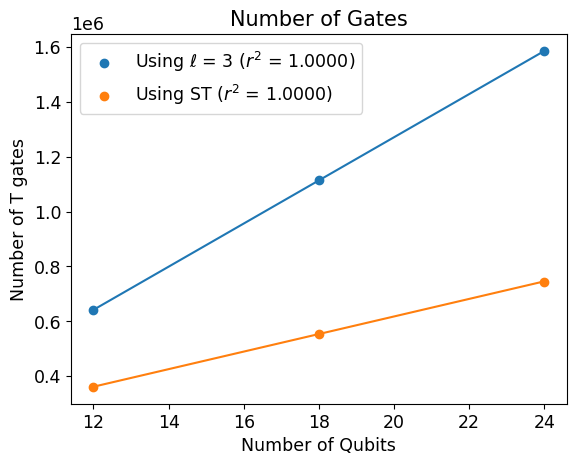

In [52]:
plt.scatter(nn, gg_lieb, label=f"Using $\\ell$ = {ell} ($r^2$ = {r2_lieb:.4f})")
plt.scatter(nn, gg_suzuki, label=f"Using ST ($r^2$ = {r2_suzuki:.4f})")
plt.plot(nn, reg_lieb)
plt.plot(nn, reg_suzuki)
plt.title(f"Number of Gates")
plt.xlabel("Number of Qubits")
plt.ylabel("Number of T gates")
plt.legend()
plt.show()